# Notebook to develop and try new ideas for figures and analysis

In [1]:
import os, sys, copy
sys.path.append('..')

import dask.dataframe as dd
from codebase.utils import *
from codebase.figures import *
from codebase.metrics import *
from codebase.params import *

import pandas as pd
import xarray as xr
from scipy import stats

In [2]:
import seaborn as sns
#sns.set(color_codes=True)
#sns.set_theme(style='white')

In [3]:
site_code = 'CCHT'

data_dir = DOWNLOAD_DIR_ROOT + site_code + '/'+ '*.tif'
obs = xr.open_dataset(OBS_PREFIX+site_code+'_obs.nc')

aoi_list = [site_code]
times = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex([i for i in obs.data_vars][:-1])]

In [4]:
obs = xr.open_dataset(OBS_PREFIX+site_code+'_obs.nc')
obs

<xarray.Dataset>
Dimensions:      (x: 4071, y: 1330, band: 7)
Coordinates:
  * x            (x) float64 8.023e+05 8.023e+05 ... 8.226e+05 8.227e+05
  * y            (y) float64 2.186e+06 2.186e+06 ... 2.179e+06 2.179e+06
  * band         (band) int32 1 2 3 4 5 6 7
Data variables:
    01-30-2010   (band, y, x) float32 ...
    09-15-2010   (band, y, x) float32 ...
    03-29-2011   (band, y, x) float32 ...
    04-22-2011   (band, y, x) float32 ...
    09-11-2011   (band, y, x) float32 ...
    01-10-2020   (band, y, x) float32 ...
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
dndvi = (obs[times[-1]][-1] - obs[times[0]][-1])

In [6]:
print('Min: ' + str(dndvi.min()) + '\nMax: ' + str(dndvi.max()))

Min: <xarray.DataArray ()>
array(-0.81167358)
Coordinates:
    band     int32 7
Max: <xarray.DataArray ()>
array(1.05170393)
Coordinates:
    band     int32 7


In [7]:
data = data_prep(obs, times)
data

NDVI
water_year season                                                   
2010       Dry     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
           Wet     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
2011       Dry     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
           Wet     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
2020       Dry     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...

In [8]:
data_box = data_prep_box(obs, times)
data_box

,water_year,season,NDVI
0,2010,Dry,-0.078788
0,2010,Dry,-0.201479
0,2010,Dry,-0.178947
0,2010,Dry,-0.161179
0,2010,Dry,-0.137746
...,...,...,...
4,2020,Dry,0.265997
4,2020,Dry,0.301088
4,2020,Dry,0.289256
4,2020,Dry,0.256353


Text(0.5, 1.0, 'Seasonal NDVI Distribution at CCHT')

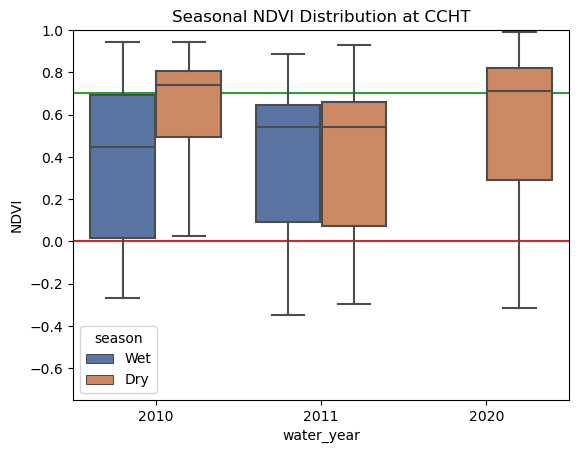

In [34]:
palette = sns.color_palette('deep')

fig, ax = plt.subplots()
hue_order = ['Wet', 'Dry']
sns.boxplot(data=data_box, x='water_year', y='NDVI', hue='season', hue_order=hue_order, palette=palette, showfliers=False, ax=ax, zorder=1);
ax.axhline(y=0.7, color='tab:green', zorder=0)
ax.axhline(y=0.0, color='tab:red', zorder=0)
#ax.fill_between(x=[-1,3], y1=0.7, y2=1, alpha=0.3, color='tab:green')
ax.set_ylim([-0.75,1]);
ax.set_title('Seasonal NDVI Distribution at '+site_code)
plt.show() 



CPU times: total: 1min 1s
Wall time: 1min 9s


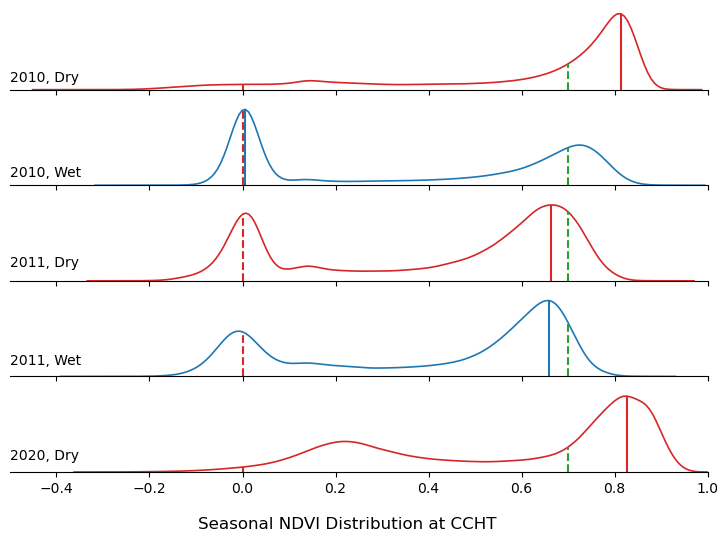

In [12]:
%%time
sn_ridgeplots(data, site_code)

In [ ]:
#Adding Min Max to metrics

In [ ]:
from scipy import stats
from sklearn.linear_model import LinearRegression

def get_conf_int(alpha, lr, X, y):
    
    """
    Returns (1-alpha) 2-sided confidence intervals
    for sklearn.LinearRegression coefficients
    as a pandas DataFrame
    """
    
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, 'const', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'lower': coefs - gap, 'upper': coefs + gap
    }, index=X_aux.columns)


def linear_fit(df, site):
    # Training data
    X = df.loc[:, ['days_from_start']]  # features
    y = df.loc[:, site]  # target

    # Train the model
    model = LinearRegression()
    model.fit(X, y)

    # Store the fitted values as a time series with the same time index as
    # the training data
    y_pred = pd.Series(model.predict(X), index=X.index)

    # Confidence interval
    
    # for 95% confidence interval; use 0.01 for 99%-CI.
    alpha = 0.05
    # fit a sklearn LinearRegression model
    ci = get_conf_int(alpha, model, X, y)


    return y_pred, ci

In [ ]:
def ndvi_calc(times, split_sites, aoi_list):
    avg_NDVI = []
    df = pd.DataFrame(columns=aoi_list)
    for i,site in enumerate(split_sites):
        avg = [site[time][-1].median().values for time in times]
        std = [site[time][-1].std().values for time in times]
        
        avg_NDVI.append(avg)
        df[aoi_list[i]] = avg
        df[aoi_list[i]+' Std'] = std
        
    df['dates'] = [datetime.strptime(date, '%m-%d-%Y').date() for date in times] 
    return df 

In [ ]:
df_NDVI = ndvi_calc(times, [obs], aoi_list)

In [ ]:
df_NDVI

In [ ]:
df_NDVI['days_from_start'] = (df_NDVI['dates'] - df_NDVI['dates'][0]).dt.days

df_NDVI['linfit'] = linear_fit(df_NDVI, site_code)[0]
# Interpolate missing date values for fit without drought points
df_NDVI['dates'] = pd.to_datetime(df_NDVI['dates'])

dates_backup = copy.deepcopy(df_NDVI['dates'].values)


df_NDVI.set_index('dates', inplace=True)
df_NDVI['linfit'] = df_NDVI['linfit'].interpolate(method='time')

df_NDVI['ndates'] = dates_backup
df_NDVI.head()

In [ ]:
def metrics_timeseries(df, site_code, title, ylabel):
    """ Plot the timeseries of specified health metric.
    
    df -- pandas Dataframe of metric to be plotted.
    Columns are, in order:
        datetimeindex, sitecode, ndates, timedelta, linfit
    site_code -- string name of site
    title -- string title of plot
    ylabel -- string y axis label
    """
    fig, ax = plt.subplots(figsize=(16,8))
    
    df_wet = df[(df['ndates'].dt.month >= 5) & (df['ndates'].dt.month <= 10)]
    df_dry = df[~((df['ndates'].dt.month >= 5) & (df['ndates'].dt.month <= 10))]
    
    df_wet.plot.scatter(x='ndates', y=site_code, ax=ax, c='tab:blue', marker='+', s=5, lw=7, zorder=0)
    df_dry.plot.scatter(x='ndates', y=site_code, ax=ax, c='tab:orange', marker='+', s=5, lw=7, zorder=0)
    
    df.plot(x='ndates', y='linfit', ax=ax, c='tab:blue', lw=3, alpha=0.2, label='Linear Fit', zorder=10)

    y_mean_wet = (df_wet[site_code].values).astype('float')
    y_std_wet = (df_wet[site_code + ' Std'].values).astype('float')
    y_mean_dry = (df_dry[site_code].values).astype('float')
    y_std_dry = (df_dry[site_code + ' Std'].values).astype('float')

    #plt.errorbar(df_wet['ndates'].values, y_mean_wet, yerr=y_std_wet, fmt='.', alpha=0.8, c='tab:blue', label='Standard Deviation')
    #plt.errorbar(df_dry['ndates'].values, y_mean_dry, yerr=y_std_dry, fmt='.', alpha=0.8, c='tab:orange', label='Standard Deviation')
    
    
    ax.set_xlim(df['ndates'].min() - timedelta(days=20), df['ndates'].max() + timedelta(days=100))
    ax.set_ylim(0.2, 1.0)
    
    ax.set_title(title)
    ax.set_xlabel('Observation Date')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(zorder=0)

    # careful with saving to not overwrite old plots, leave this commented by default
    plt.savefig('../outputs/Final Figures/new_ndvi_'+site_code+'.png', dpi=800, bbox_inches='tight', transparent=True)

    plt.show();

In [ ]:
metrics_timeseries(df_NDVI, site_code, 'NDVI Timeseries', 'NDVI')